# Example 2: 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [ ]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [ ]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05']

# list of session identifiers
session_list = ['run-1', 'run-2']

# TR of functional images
TR = 2

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had two different conditions in this dataset:

- **congruent** - Flanker stimuli: ``< < < < <``
- **incongruent** - Flanker stimuli: ``< < > < <``

Therefore, we could create the following contrasts:

In [ ]:
# Condition names
condition_names = ['congruent', 'incongruent']

# Contrasts
cont01 = ['average',        'T', condition_names, [0.5, 0.5]]
cont02 = ['congruent',      'T', condition_names, [1, 0]]
cont03 = ['incongruent',    'T', condition_names, [0, 1]]
cont04 = ['cong > incong',  'T', condition_names, [1, -1]]
cont05 = ['incong > cong',  'T', condition_names, [-1, 1]]

cont06 = ['activation',     'F', [cont02, cont03]]
cont07 = ['differences',    'F', [cont04, cont05]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [ ]:
!cat /data/ds102/sub-01/func/sub-01_task-flanker_run-1_events.tsv

onset	duration	trial_type	response_time	correctness	StimVar	Rsponse	Stimulus	cond
0.0	2.0	incongruent_correct	1.095	correct	2	1	incongruent	cond003
10.0	2.0	incongruent_correct	0.988	correct	2	1	incongruent	cond003
20.0	2.0	congruent_correct	0.591	correct	1	1	congruent	cond001
30.0	2.0	congruent_correct	0.499	correct	1	1	congruent	cond001
40.0	2.0	incongruent_correct	0.719	correct	2	1	incongruent	cond003
52.0	2.0	congruent_correct	0.544	correct	1	1	congruent	cond001
64.0	2.0	congruent_correct	0.436	correct	1	1	congruent	cond001
76.0	2.0	incongruent_correct	0.47	correct	2	1	incongruent	cond003
88.0	2.0	congruent_correct	0.409	correct	1	1	congruent	cond001
102.0	2.0	incongruent_correct	0.563	correct	2	1	incongruent	cond003
116.0	2.0	congruent_correct	0.493	correct	1	1	congruent	cond001
130.0	2.0	congruent_correct	0.398	correct	1	1	congruent	cond001
140.0	2.0	congruent_correct	0.466	correct	1	1	congruent	cond001
150.0	2.0	incongruent_correct	0.518	correct	2	1	incongruent	cond003
164.0	2.0

So what we need is the onset and the stimuli type, i.e. **column 0** and **column 5 or 7**.

In [ ]:
filename = '/data/ds102/sub-01/func/sub-01_task-flanker_run-1_events.tsv'
trailinfo = np.genfromtxt(filename, delimiter='\t', dtype=None, skip_header=1)
trailinfo = [[t[0], t[7]] for t in trailinfo]
trailinfo

[[0.0, 'incongruent'],
 [10.0, 'incongruent'],
 [20.0, 'congruent'],
 [30.0, 'congruent'],
 [40.0, 'incongruent'],
 [52.0, 'congruent'],
 [64.0, 'congruent'],
 [76.0, 'incongruent'],
 [88.0, 'congruent'],
 [102.0, 'incongruent'],
 [116.0, 'congruent'],
 [130.0, 'congruent'],
 [140.0, 'congruent'],
 [150.0, 'incongruent'],
 [164.0, 'incongruent'],
 [174.0, 'incongruent'],
 [184.0, 'congruent'],
 [196.0, 'congruent'],
 [208.0, 'incongruent'],
 [220.0, 'incongruent'],
 [232.0, 'incongruent'],
 [246.0, 'congruent'],
 [260.0, 'incongruent'],
 [274.0, 'congruent']]

And finally we need to separate the onsets of the two stimuli. This can be done as follows:

In [ ]:
onset1 = []
onset2 = []

for t in trailinfo:
    if 'incongruent' in t[1]:
        onset2.append(t[0])
    else:
        onset1.append(t[0])

print onset1
print onset2

[20.0, 30.0, 52.0, 64.0, 88.0, 116.0, 130.0, 140.0, 184.0, 196.0, 246.0, 274.0]
[0.0, 10.0, 40.0, 76.0, 102.0, 150.0, 164.0, 174.0, 208.0, 220.0, 232.0, 260.0]


Now, let us incorporate all this in the helper function ``subjectinfo``.

In [ ]:
def subjectinfo(subject_id):

    import numpy as np
    from os.path import join as opj
    from nipype.interfaces.base import Bunch

    condition_names = ['congruent', 'incongruent']

    logfile_dir = opj('/data', 'ds102', subject_id, 'func')

    for sess in ['run-1', 'run-2']:

        # Read the TSV file
        filename = opj(logfile_dir,
                       '%s_task-flanker_%s_events.tsv' % (subject_id, sess))

        # Save relevant information
        trailinfo = np.genfromtxt(filename, delimiter='\t',
                                  dtype=None, skip_header=1)
        trailinfo = [[t[0], t[7]] for t in trailinfo]

        # Separate onset of conditions
        onset1 = []
        onset2 = []

        for t in trailinfo:
            if 'incongruent' in t[1]:
                onset2.append(t[0])
            else:
                onset1.append(t[0])

        # Svae values per session
        if sess == 'run-1':
            run1 = [onset1, onset2]
        elif sess == 'run-2':
            run2 = [onset1, onset2]

    subjectinfo = []
    for r in range(2):
        if r == 0:
            onsetTimes = run1
        elif r == 1:
            onsetTimes = run2

        subjectinfo.insert(r,
                           Bunch(conditions=condition_names,
                                 onsets=onsetTimes,
                                 durations=[[2.0], [2.0]],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None,
                                 regressor_names=None,
                                 regressors=None))

    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}',
                         'run-*_fwhm_{fwhm_id}', 's_bold_mcf_flirt.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}',
                             'run-*_bold_mcf.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

# Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

# Visualize the workflow

It always helps to visualize your workflow.

170301-21:35:13,964 workflow INFO:
	 Converting dotfile: /output/workingdir/l1analysis/graph.dot to png format


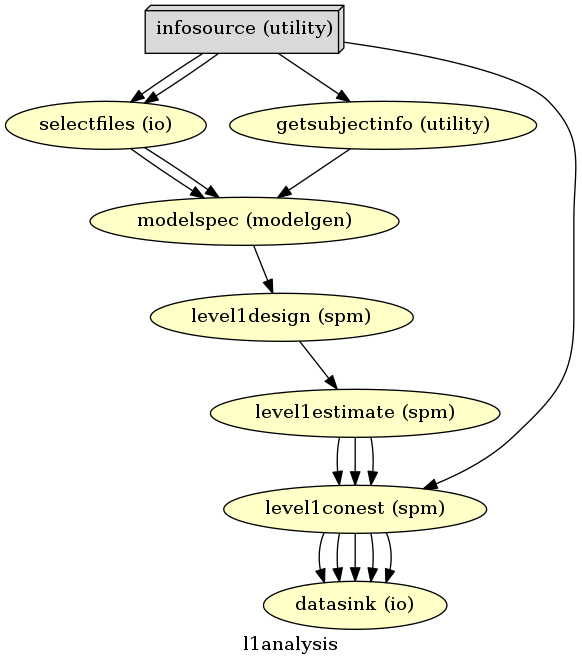

In [ ]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

#  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

# Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [ ]:
!tree /output/datasink/1stLevel/sub-01*

/output/datasink/1stLevel/sub-01_fwhm4
├── con_0001.nii
├── con_0002.nii
├── con_0003.nii
├── con_0004.nii
├── con_0005.nii
├── ess_0006.nii
├── ess_0007.nii
├── spmF_0006.nii
├── spmF_0007.nii
├── SPM.mat
├── spmT_0001.nii
├── spmT_0002.nii
├── spmT_0003.nii
├── spmT_0004.nii
└── spmT_0005.nii
/output/datasink/1stLevel/sub-01_fwhm8
├── con_0001.nii
├── con_0002.nii
├── con_0003.nii
├── con_0004.nii
├── con_0005.nii
├── ess_0006.nii
├── ess_0007.nii
├── spmF_0006.nii
├── spmF_0007.nii
├── SPM.mat
├── spmT_0001.nii
├── spmT_0002.nii
├── spmT_0003.nii
├── spmT_0004.nii
└── spmT_0005.nii

0 directories, 30 files


# Visualize results

let's look at the contrasts that we've computed. First, let's see what the difference of smoothing is for the contrast **`average`**

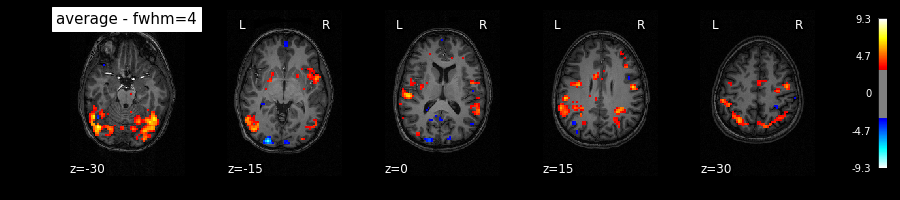

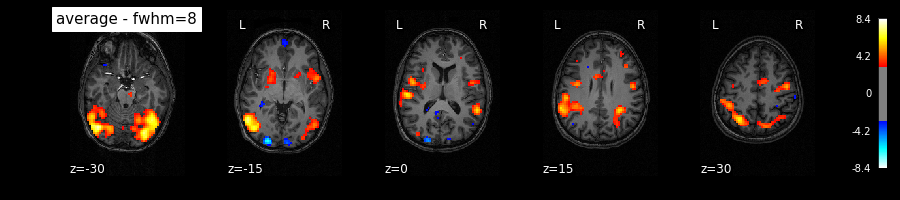

In [ ]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds102/sub-01/anat/sub-01_T1w.nii.gz'
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)

Now, let's look at the two contrasts **`congruent`** and **`incongruent`**, as well as the difference contrasts **`cong > incong`**.

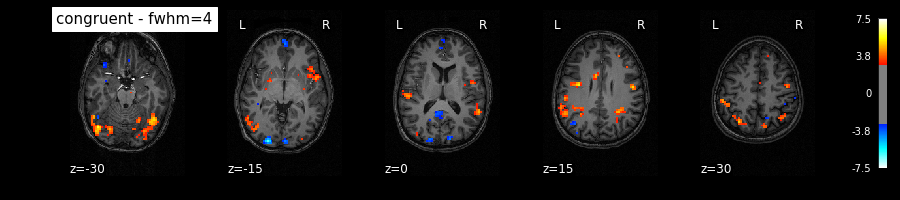

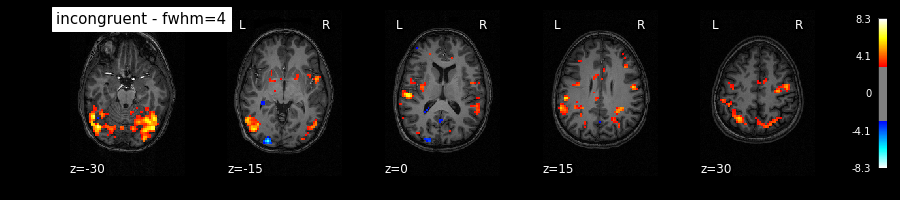

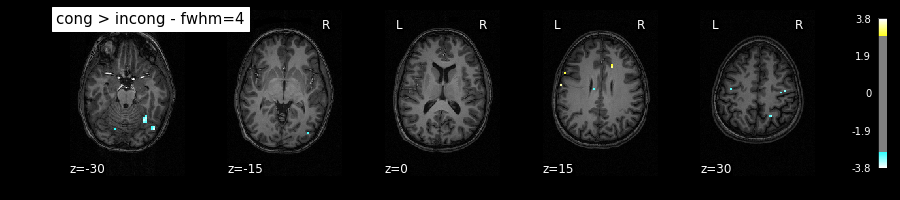

In [ ]:
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0002.nii', title='congruent - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0003.nii', title='incongruent - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0004.nii', title='cong > incong - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)